In [1]:
import os

os.environ['PROJ_LIB'] = r'C:\Users\QM\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz

import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
#import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

#%matplotlib qt
#%matplotlib notebook
%matplotlib inline
#import cmocean
print("Done!")

Done!


In [37]:
ride_ids = ['16090']
# 13735 - One of Phil's Smartfin Surf Session Rides
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th (4Hz data at MESOM Lab)
# 14816 - Compass Orientation (Lying with LED down) July 20th (30Hz data at CSE UCSD)
# 14827 - Pool Displacement Control July 23rd (30Hz at CSE UCSD)
# 14840 - MESOM Parking Lot Static Rotation Combined Tracking (30Hz)
# 14865 - Martz Lab Rotation Vertical Component Manual Test (30Hz)
# 14888 - CDIP Buoy Calibration Run #1 July 30 (Fin in vertical position, pointing upwards)
# 14893 and 14894 - Junk files to drain battery (stationary tests an hour long at constant 30Hz)
# 14902 - Junk data when fin accidentally turn on while walking to beach for magneto calibration
# 14903 - Beach magnetometer calibration (y-x plane (horizontal or yaw) rotation of surfboard frame) August 3rd
# 14904 - Beach magnetometer calibration (x-z plane (lengthwise or pitch) rotation of surfboard frame) August 3rd
# 14905 - Beach magnetometer calibration (y-z plane (crosswise or roll) rotation of surfboard frame) August 3rd
# 15138 - First Ocean Data Experiment "Sitting" (August 20)
# 16083 - Floating Next to CDIP Buoy (May 15)
# 16090 - Orientation Calibration Sitting Outside CSE Building (May 21)
print("Ride",ride_ids,"loaded up.")

Ride ['16090'] loaded up.


In [38]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
print("Done.")

Done.


In [39]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)

https://surf.smartfin.org/ride/16090
https://surf.smartfin.org/media/201905/google_102620292919180005796_0006667E228E_190521211219_Ocean.CSV
                                     Time  Temperature 1  \
UTC                                                        
2019-05-21 21:12:28.806000+00:00    28897            441   
2019-05-21 21:12:34.826000+00:00    34917            439   
2019-05-21 21:12:40.846000+00:00    40937            437   
2019-05-21 21:12:46.867000+00:00    46957            434   
2019-05-21 21:12:52.887000+00:00    52977            432   
2019-05-21 21:12:58.912000+00:00    59001            429   
2019-05-21 21:13:04.932000+00:00    65021            426   
2019-05-21 21:13:10.952000+00:00    71041            424   
2019-05-21 21:13:16.973000+00:00    77061            420   
2019-05-21 21:13:22.992000+00:00    83080            418   
2019-05-21 21:13:29.013000+00:00    89100            415   
2019-05-21 21:13:35.033000+00:00    95120            413   
2019-05-21 21:13:41

In [40]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data

print(saved_copy_motion_df)

                                               Time  IMU A1  IMU A2  IMU A3  \
ride_id UTC                                                                   
16090   2019-05-21 21:12:29.229000+00:00    29334.0   -29.0    -1.0   524.0   
        2019-05-21 21:12:29.262000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.295000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.328000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.361000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.394000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.427000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.460000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.493000+00:00    29590.0   -29.0    -2.0   524.0   
        2019-05-21 21:12:29.526000+00:00        NaN     NaN     NaN     NaN   
        2019-05-21 21:12:29.559000+00:00        NaN 

In [41]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 
                                            'IMU M2', 'IMU M3'])
#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []
imuA1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array_A1 = []
imuA2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array_A2 = []
imuA3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array_A3 = []
imuG1_array_nans = np.array(dropped_motion_df.loc[:,"IMU G1"], dtype=float)
imu_array_G1 = []
imuG2_array_nans = np.array(dropped_motion_df.loc[:,"IMU G2"], dtype=float)
imu_array_G2 = []
imuG3_array_nans = np.array(dropped_motion_df.loc[:,"IMU G3"], dtype=float)
imu_array_G3 = []
imuM1_array_nans = np.array(dropped_motion_df.loc[:,"IMU M1"], dtype=float)
imu_array_M1 = []
imuM2_array_nans = np.array(dropped_motion_df.loc[:,"IMU M2"], dtype=float)
imu_array_M2 = []
imuM3_array_nans = np.array(dropped_motion_df.loc[:,"IMU M3"], dtype=float)
imu_array_M3 = []

#Get all the times and imus where time, imu a1, imu a2, and imu a3 are NOT nan values:
for t,x,y,z,a,b,c,d,e,f in zip(time_array_nans, imuA1_array_nans, imuA2_array_nans, imuA3_array_nans, imuG1_array_nans, 
                              imuG2_array_nans, imuG3_array_nans, imuM1_array_nans, imuM2_array_nans, imuM3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array_A1.append(x)
        imu_array_A2.append(y)
        imu_array_A3.append(z)
        imu_array_G1.append(a)
        imu_array_G2.append(b)
        imu_array_G3.append(c)
        imu_array_M1.append(d)
        imu_array_M2.append(e)
        imu_array_M3.append(f)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1

##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array_A1[-1])
del(imu_array_A2[-1])
del(imu_array_A3[-1])
del(imu_array_G1[-1])
del(imu_array_G2[-1])
del(imu_array_G3[-1])
del(imu_array_M1[-1])
del(imu_array_M2[-1])
del(imu_array_M3[-1])
    
#print(len(time_e_list))
#print(len(time_o_list))
#print(len(imu_array_A1))
#print(len(imu_array_A2))
#print(len(imu_array_A3))
#print(len(imu_array_G1))
#print(len(imu_array_G2))
#print(len(imu_array_G3))
#print(len(imu_array_M1))
#print(len(imu_array_M2))
#print(len(imu_array_M3))
print("Done.")

Done.


5648
5648
5648


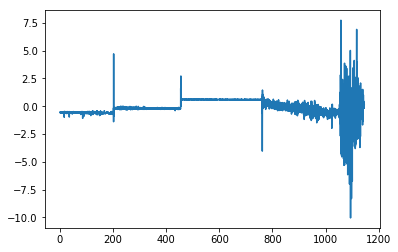

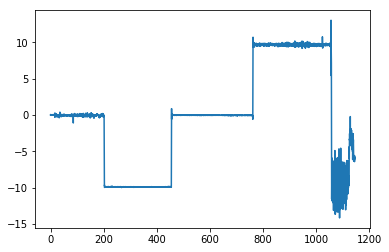

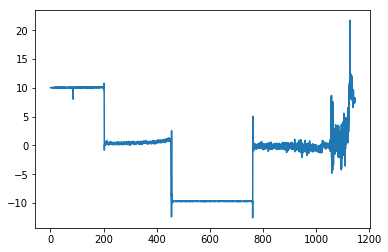

In [42]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])
#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512
gyro_const = 8.2      # Raw gyrscope constant 8.2 bits per degree

gravity = 9.80665     # Approximate measurement for gravity

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??) --> Not yet, we'll do it later on
        new_a = a / g_const * gravity# - gravity
        ret_array.append(new_a)
    return ret_array

imuA1_array = convert_acc_units(imu_array_A1) #new units in m/s^2
imuA2_array = convert_acc_units(imu_array_A2) #new units in m/s^2
imuA3_array = convert_acc_units(imu_array_A3) #new units in m/s^2

##To check:
#for x,y in zip(imuA2_array, imu_array_A2):
    #print(x,y)
    
def convert_gyr_units(gyr_array):
    ret_array = []
    for g in gyr_array:
        # Gyroscopic Rotation converts to deg/s
        new_g = g / gyro_const
        ret_array.append(new_g)
    return ret_array

imuG1_array_not_cal = convert_gyr_units(imu_array_G1) #new units in deg/s (will need to be rads for some later functions)
imuG2_array_not_cal = convert_gyr_units(imu_array_G2)
imuG3_array_not_cal = convert_gyr_units(imu_array_G3)

#To check:
#for x,y in zip(imuG2_array, imu_array_G2):
    #print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds

##To check:
#for t in time_e_array:
#    print(t)

print(len(time_e_array))
print(len(time_e_list))
print(len(imuA2_array))

#print(imuA1_array)
#print(rotmat.R(imuA1_array, ___))

plt.plot(time_e_array, imuA1_array)
plt.show()
plt.plot(time_e_array, imuA2_array)
plt.show()
plt.plot(time_e_array, imuA3_array)
plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG2_array)
#plt.show()

#print("Gyro_plot:")
#plt.plot(time_e_array, imuG1_array_not_cal)
#plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG1_array)
#plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG2_array_not_cal)
#plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG2_array)
#plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG3_array_not_cal)
#plt.show()
#print("Gyro_plot:")
#plt.plot(time_e_array, imuG3_array)
#plt.show()

#print("Why are the y-axis values so small?")

The current threshold value is: 0.6097560975609757
Total rows of data: 5648
Current position skipped unexpectedly past next calibration window.
5647
The current threshold value is: 0.6097560975609757
Total rows of data: 5648
Current position skipped unexpectedly past next calibration window.
5647
The current threshold value is: 0.6097560975609757
Total rows of data: 5648
Current position skipped unexpectedly past next calibration window.
5647
[[1.4634146341463417 array([-0.05712001])]
 [1.4634146341463417 array([-0.05712001])]
 [1.4634146341463417 array([-0.05712001])]
 ...
 [2.3170731707317076 array([0.73378922])]
 [9.02439024390244 array([7.44110629])]
 [-0.853658536585366 -0.853658536585366]]
Done calibrating.
Gyro_plot:


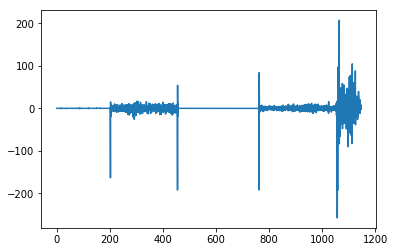

Gyro_plot:


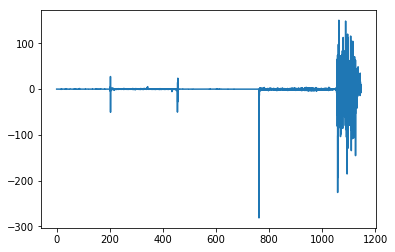

Gyro_plot:


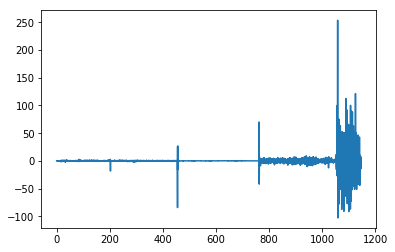

In [43]:
def adaptive_gyroscope_calibration(gyr, thresh):
    # Takes in gyroscope array [1xN] and a threshold value in deg/s
    print("The current threshold value is:",thresh)       # Prints the threshold
    ret_array = gyr.copy()                            # Initialize the calibrated return array (which will be calibrated and returned)
    calibration_constant = 0                              # Initialize loop variables
    last_touched_value = 0
    calibration_was_attempted = 0
    current = 0
    #calibrations_completed = 0
    calarray_pos = np.zeros(shape=(500,1))                  #Initialize an array to store calibration constant positions in (made excessively large for longer sessions)
    calarray_constants = np.zeros(shape=(500,1))            #Initialize an array to store calibration constant values
    print("Total rows of data:", len(gyr))
    
    calibration_was_attempted = 0     # Reset all state variables
    last_touched_value = 0
    calibrations_completed = 0
    current = 0                       # Reset iterator
    while current < len(gyr) - 100:
    #for current in range(len(gyr)):
        calibration_was_attempted = 0                 #Reset the state of calibration attempted
        curr_pos = gyr[current]
        next_pos = gyr[current+1]
        difference = next_pos - curr_pos          #Find the delta between current and next value
        
        if (difference < thresh) and (difference > -1*thresh):   #If the delta is within the threshold:
            calibration_was_attempted = 1                        #Change state: calibration_was_attempted to true
            start_average = current                              #Mark the start of a potential averaging window
            end_average = current+1                              #Initialize the end of a potential averaging window (size 1 to be safe)
            next_seven_fail = 0                                  #Initialize variable to tell if next 7 deltas were within threshold
            end_of_deltas = 0                                    #Initialize variable to tell when delta is no longer within threshold
            final_sev_check_pos = 0                              #Initialize variable to hold marker at the last seven check position
           
            for seven_check in range(7):                                       # Check the next 7 deltas (1/4 second @ 30Hz) to get min window
                sev_check_curr_pos = gyr[current+seven_check+1]
                sev_check_next_pos = gyr[current+seven_check+2]
                sev_check_difference = sev_check_next_pos - sev_check_curr_pos
                if (sev_check_difference > thresh) or (sev_check_difference < -1*thresh):  # If at any point a delta is not within threshold, then stop and start over
                    next_seven_fail = 1                         #Change failure status of seven_check to TRUE
                    final_sev_check_pos = current+seven_check+1
                    last_touched_value = current+seven_check+1  #Update the last_touched_value by the loop
                    break                                       #Break out of the loop and restart
                final_sev_check_pos = current+seven_check+1     #Update the last position in seven_check
                end_average = final_sev_check_pos               #Update the end of the averaging window
                last_touched_value = end_average                #Update the last touched value
            
            if next_seven_fail == 0:                      #If the next seven deltas are within threshold, continue looking for last valid delta (if seven_check failed, then this loop shouldn't run)
                iterator = 0
                while (end_of_deltas == 0) and (not (gyr[final_sev_check_pos+iterator] is None)):
                    #while we haven't found the last valid delta, AND the next value isn't empty/DNE
                    if final_sev_check_pos+iterator+1 >= len(gyr):
                        end_of_deltas = 1
                        end_average = final_sev_check_pos+iterator
                        last_touched_value = end_average
                    else:
                        finding_end_curr_pos = gyr[final_sev_check_pos+iterator]
                        finding_end_next_pos = gyr[final_sev_check_pos+iterator+1]
                        finding_end_difference = finding_end_next_pos - finding_end_curr_pos
                        if (finding_end_difference >= thresh) or (finding_end_difference <= -1*thresh):      #if difference is outside threshold, enter "end found" state
                            end_of_deltas = 1                                     #Set "end found" state to true
                            end_average = final_sev_check_pos+iterator            #Mark ending of window with the last valid delta position
                            last_touched_value = end_average                      #Update the last touched value
                            break
                        iterator += 1
                averaging_pos = start_average
                total_sum = 0
                num_of_nums = 0
                while (averaging_pos < end_average) and (averaging_pos < len(gyr)-1):	#Start averaging the values within the averaging window
                    total_sum += gyr[averaging_pos]
                    num_of_nums += 1
                    averaging_pos += 1
                calibration_constant = total_sum / num_of_nums
                calarray_pos[calibrations_completed] = current #Store calibration start location into an array
                calarray_constants[calibrations_completed] = calibration_constant #Store calibrations into an array
                calibrations_completed += 1
                #print("Start of the average was",start_average)
                #print("Position of the last touched value was",last_touched_value)
                #print("Newest calibration calculated:",calibration_constant)
        if calibration_was_attempted == 1:
            current = last_touched_value     #Assign current to the last value looked at by the loop, to avoid redundant searches
        else:
            current += 1
    
    cal_pos_iterator = 0     # Iterator to point to next upcoming calibration position, so we know when to change calibration value
    for i in range(len(ret_array)):
        if cal_pos_iterator == 0:     # Unique case for setting the first calibration constant
            enforcer = calarray_constants[0]
            cal_pos_iterator = 1
            #cal_value_iterator = 1
            ret_array[i] -= enforcer
        else:
            if i < calarray_pos[cal_pos_iterator] and i < len(ret_array)-1:       # if the current position hasn't reached the start of the next calibration window
                ret_array[i] -= enforcer
            elif i == calarray_pos[cal_pos_iterator] and i < len(ret_array)-1:    # if the current position is at the start of the next calibration window
                enforcer = calarray_constants[cal_pos_iterator]
                cal_pos_iterator += 1
                ret_array[i] -= enforcer
            elif i > calarray_pos[cal_pos_iterator] and i < len(ret_array)-1 and calarray_pos[cal_pos_iterator] == 0:
                ret_array[i] -= enforcer
            else:
                print("Current position skipped unexpectedly past next calibration window.")
                print(i)
                break
    return ret_array


threshold = 5 / 8.2  # Set the threshold that passes to the calibration function
imuG1_array = adaptive_gyroscope_calibration(imuG1_array_not_cal, threshold)
imuG2_array = adaptive_gyroscope_calibration(imuG2_array_not_cal, threshold)
imuG3_array = adaptive_gyroscope_calibration(imuG3_array_not_cal, threshold)

G1_comparison = np.stack((imuG1_array_not_cal, imuG1_array), axis=-1)
print(G1_comparison)
print("Done calibrating.")

print("Gyro_plot:")
plt.plot(time_e_array, imuG1_array)
plt.show()
print("Gyro_plot:")
plt.plot(time_e_array, imuG2_array)
plt.show()
print("Gyro_plot:")
plt.plot(time_e_array, imuG3_array)
plt.show()

In [44]:
# Offset variables help in recentering the magnetic data in order to define direction and use trig functions
#     for some calculations. These values were estimated from data collected from multiple tests and hold fairly well.
# Magnetic data is relative, so as long as all of the axis share similar magnitude in value, then data should be fine
M1_offset_var = 219.786
M2_offset_var = 180
M3_offset_var = 280

def calibrate_magn_data(magn_array, offset_value):
    ret_array = []
    for m in magn_array:
        new_m = m - offset_value
        ret_array.append(new_m)
    return ret_array

imuM1_array = calibrate_magn_data(imu_array_M1, M1_offset_var)
imuM2_array = calibrate_magn_data(imu_array_M2, M2_offset_var)
imuM3_array = calibrate_magn_data(imu_array_M3, M3_offset_var)

#print(imu_array_M1)
#print(imuM1_array)
print("Done.")

Done.


In [45]:
# Create N x 3 arrays for functions that need them later on, such as Scikit Kinematics
acc_height = len(imuA1_array)
print(acc_height)
gyr_height = len(imuG1_array)
magn_height = len(imuM1_array)

acc_array = np.zeros(shape=(acc_height,3))
gyr_array = np.zeros(shape=(gyr_height,3))
magn_array = np.zeros(shape=(magn_height,3))

for x in range(len(acc_array)):
    acc_array[x,0] = imuA1_array[x]
    acc_array[x,1] = imuA2_array[x]
    acc_array[x,2] = imuA3_array[x]
#print(acc_array)

for x in range(len(gyr_array)):
    gyr_array[x,0] = imuG1_array[x]
    gyr_array[x,1] = imuG2_array[x]
    gyr_array[x,2] = imuG3_array[x]
#print(gyr_array)

for x in range(len(magn_array)):
    magn_array[x,0] = imuM1_array[x]
    magn_array[x,1] = imuM2_array[x]
    magn_array[x,2] = imuM3_array[x]
#print(magn_array)
print("Done.")

5648
Done.


In [46]:
# The new array for board reference frame will have the IMUs in columns according to X,Y,Z directions
board_acc = acc_array.copy()       # Reassign to the correct axes as stated above
temp_x_acc = board_acc[:,0] * (-1)
temp_y_acc = board_acc[:,2] * (-1)
temp_z_acc = board_acc[:,1] * (-1)
board_acc[:,0] = temp_x_acc     # X acceleration
board_acc[:,1] = temp_y_acc     # Y acceleration
board_acc[:,2] = temp_z_acc     # Z acceleration

#print('X              ', 'Y              ', 'Z')
#print(acc_array[:4,:])
#print(board_acc[:4,:])     # Display check to see if they are properly assigned
board_gyr = gyr_array.copy()
temp_x_gyr = board_gyr[:,0] * (-1)
temp_y_gyr = board_gyr[:,2] * (-1)
temp_z_gyr = board_gyr[:,1] * (-1)
board_gyr[:,0] = temp_x_gyr
board_gyr[:,1] = temp_y_gyr
board_gyr[:,2] = temp_z_gyr

board_magn = magn_array.copy()
temp_x_magn = board_magn[:,0] * (-1)
temp_y_magn = board_magn[:,2] * (-1)
temp_z_magn = board_magn[:,1] * (-1)
board_magn[:,0] = temp_x_magn
board_magn[:,1] = temp_y_magn
board_magn[:,2] = temp_z_magn
print("Done.")

Done.


In [47]:
print(board_acc)
#print(board_gyr)
#print(board_magn)

[[  0.55545479 -10.03649336   0.01915361]
 [  0.55545479 -10.03649336   0.03830723]
 [  0.5746084  -10.03649336  -0.07661445]
 ...
 [  0.19153613  -8.31266816   5.82269844]
 [ -0.03830723  -7.39329473   6.03338818]
 [ -0.13407529  -8.04451758   5.68862314]]


# THIS IS WHERE I DO ORIENTATION ROTATION MATRIX

In [49]:
import numpy as np
from sklearn import preprocessing
import math

board_acc_norms = preprocessing.normalize(board_acc, norm='l2')
board_magn_norms = preprocessing.normalize(board_magn, norm='l2')

#print(board_acc[0])
#print(board_acc_norms[0])
gravity_vec = board_acc_norms[0]
entry_1_1 = (math.pow(gravity_vec[1], 2) - (math.pow(gravity_vec[0], 2) * gravity_vec[2]))
entry_1_1 /= (math.pow(gravity_vec[0], 2) + math.pow(gravity_vec[1], 2))
entry_2_1 = (-(gravity_vec[0] * gravity_vec[1]) - (gravity_vec[0] * gravity_vec[1] * gravity_vec[2]))
entry_2_1 /= (math.pow(gravity_vec[0], 2) + math.pow(gravity_vec[1], 2))
entry_3_1 = -gravity_vec[0]
first_column = np.array([entry_1_1, entry_2_1, entry_3_1])
entry_1_2 = entry_2_1
entry_2_2 = (math.pow(gravity_vec[0], 2) - (math.pow(gravity_vec[1], 2) * gravity_vec[2]))
entry_2_2 /= (math.pow(gravity_vec[0], 2) + math.pow(gravity_vec[1], 2))
entry_3_2 = -gravity_vec[1]
second_column = np.array([entry_2_1, entry_2_2, entry_3_2])
third_column = np.array([gravity_vec[0], gravity_vec[1], -gravity_vec[2]])
rotation_matrix = np.column_stack((first_column, second_column, third_column))
gravity_as_np = np.array(gravity_vec)
gravity_after_rotation = np.matmul(rotation_matrix, np.transpose(gravity_as_np))
print(gravity_after_rotation)

ent_1_1 = 1 / (math.sqrt(1 + (math.pow(gravity_vec[1], 2) / math.pow(gravity_vec[0], 2))))
ent_2_1 = gravity_vec[1] / (gravity_vec[0] * (math.sqrt(1 + (math.pow(gravity_vec[1], 2) / math.pow(gravity_vec[0], 2)))))
first_col = np.array([ent_1_1, ent_2_1, 0])
ent_1_2 = -ent_2_1
ent_2_2 = ent_1_1
second_col = np.array([ent_1_2, ent_2_2, 0])
third_col = np.array([0, 0, 1])
rot_matrix = np.column_stack((first_col, second_col, third_col))

board_acc_rotation = board_acc.copy()
for x in range(len(board_acc_rotation)):
    board_acc_rotation[x] = np.matmul(rotation_matrix, np.transpose(board_acc_rotation[x]))
    
board_magn_rotation = board_magn.copy()
for x in range(len(board_magn_rotation)):
    board_magn_rotation[x] = np.matmul(rot_matrix, np.transpose(board_magn_rotation[x]))
#print(board_acc_norms)
#print(board_magn_norms)
#north_vec = board_magn_norms[0]
#down_vec = board_acc_norms[0]
#east_vec = np.cross(down_vec, north_vec)
#rotation_matrix = np.column_stack((north_vec, east_vec, down_vec))
#print(rotation_matrix)
#rotation_matrix = np.transpose(rotation_matrix)
#print(rotation_matrix)

[-6.77626358e-18  0.00000000e+00 -1.00000000e+00]


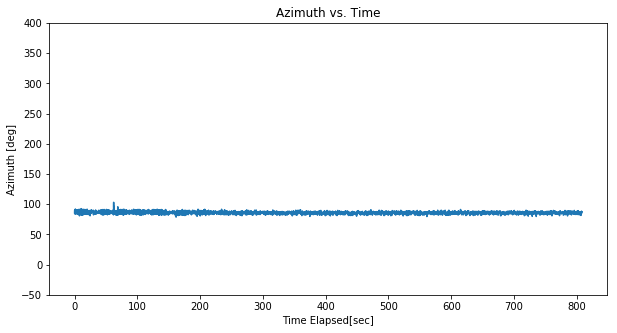

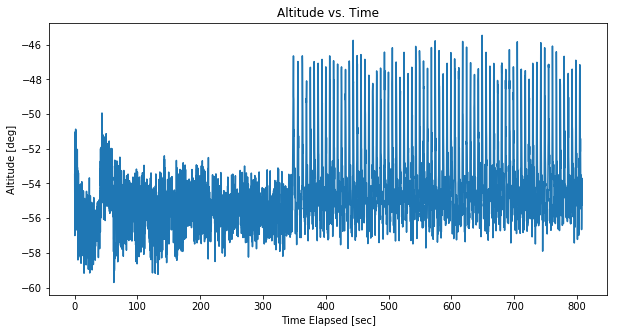

In [30]:
# This will get complicated (ie make cases or lots of if statements) when rotations about the heading become more prevalent
def azimuth(x,y,z):
    real_y = y * (-1) # This is to account for y 
    return (180/math.pi * math.atan2(real_y,x)) % 360

def altitude(x,y,z):
    h = math.hypot(y, x)
    return 180/math.pi * math.atan2(z,h)

def printAltAzi(alt, azi):
    print ("Alt:", alt, "\n", "Azi:",azi,"\n")
# These values are uncorrected values: still need to add or subtract 'declination'
#     (for AziMuth) and 'inclination' (for Altitude) correction values for geographical location
# Altitude is the angle between the ground and the vector 
# Azimuth is the angle going clockwise from 0 deg North

heading_altitude = board_magn[:,0].copy()
heading_azimuth = board_magn[:,0].copy()

i = 0     #iterator
#for i in range(len(M1_no_out)):
while i < len(heading_altitude):
    heading_altitude[i] = altitude(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    heading_azimuth[i] = azimuth(board_magn[i,0], board_magn[i,1], board_magn[i,2])
    #printAltAzi(heading_altitude[i],heading_azimuth[i])
    i += 1

heading_azi_plot = plt.figure(figsize=(10,5))
azi_plot = heading_azi_plot.add_subplot(111)
azi_plot.plot(time_e_array, heading_azimuth)
azi_plot.set_title("Azimuth vs. Time")
azi_plot.set_xlabel("Time Elapsed[sec]")
azi_plot.set_ylabel("Azimuth [deg]")
azi_plot.set_ylim([-50,400])

heading_alt_plot = plt.figure(figsize=(10,5))
alt_plot = heading_alt_plot.add_subplot(111)
alt_plot.plot(time_e_array, heading_altitude)
alt_plot.set_title("Altitude vs. Time")
alt_plot.set_xlabel("Time Elapsed [sec]")
alt_plot.set_ylabel("Altitude [deg]")
plt.show()

In [31]:
# Enter the EXACT number that is shown for declination (since yaw and azimuth opposite directions/signs)
# Enter the EXACT number that is shown for inclination
declination = 11.5
inclination = 57.87
LFF_fick_yaw = (-1)*declination
LFF_fick_pitch = inclination
LFF_fick_roll = 0

# Convert angles entered to radians for trig functions
Y = np.deg2rad(LFF_fick_yaw)
P = np.deg2rad(LFF_fick_pitch)
R = np.deg2rad(LFF_fick_roll)
# Set up the Fick angle matrix
c11 = np.cos(Y)*np.cos(P)
c12 = np.cos(Y)*np.sin(P)*np.sin(R) - np.sin(Y)*np.sin(R)
c13 = np.cos(Y)*np.sin(P)*np.cos(R) + np.sin(Y)*np.sin(R)
c21 = np.sin(Y)*np.cos(P)
c22 = np.sin(Y)*np.sin(P)*np.sin(R) + np.cos(Y)*np.cos(R)
c23 = np.sin(Y)*np.sin(P)*np.cos(R) - np.cos(Y)*np.sin(R)
c31 = (-1)*np.sin(P)
c32 = np.cos(P)*np.sin(R)
c33 = np.cos(P)*np.cos(R)

rotmat_lff2mag = np.array([[c11, c12, c13],
                        [c21, c22, c23],
                        [c31, c32, c33]])

print("rotmat_lff2mag: \n", rotmat_lff2mag, "\n")
lff2mag_rad = rotmat.sequence(rotmat_lff2mag, 'Fick') # Check if the matrix accurately represents the desired Fick angles
lff2mag_deg = lff2mag_rad * 180/np.pi
print("lff2mag_deg Fick Angles: \n", lff2mag_deg,"\n")

# Now find the inverse of the matrix, since we want to go from magnetic field to LFF
#rotmat_mag2lff = np.matrix.transpose(rotmat_lff2mag)
rotmat_mag2lff = np.linalg.inv(rotmat_lff2mag)
print("rotmat_mag2lff: \n", rotmat_mag2lff, "\n")
mag2lff_rad = rotmat.sequence(rotmat_mag2lff, 'Fick')
mag2lff_deg = mag2lff_rad * 180/np.pi
print("mag2lff_deg Fick Angles: \n", mag2lff_deg, "\n")

print("Is it identity matrix?: \n", np.matmul(rotmat_lff2mag,rotmat_mag2lff))
mag2lff_helm_rad = rotmat.sequence(rotmat_mag2lff, 'Helmholtz')
mag2lff_helm_deg = mag2lff_helm_rad * 180/np.pi
print("mag2lff_deg Helmholtz Angles: \n", mag2lff_helm_deg, "\n")

Q_mag2lff = rotmat.seq2quat(mag2lff_deg, 'Fick')
print("Transformation Quaternion for mag2lff: \n", Q_mag2lff) #Print out quaternion describing the transformation

rotmat_lff2mag: 
 [[ 0.52116517  0.          0.82984293]
 [-0.10603225  0.9799247  -0.16883345]
 [-0.84684357  0.          0.53184206]] 

lff2mag_deg Fick Angles: 
 [-11.5   57.87   0.  ] 

rotmat_mag2lff: 
 [[ 5.42737678e-01 -0.00000000e+00 -8.46843566e-01]
 [ 2.07620339e-01  1.02048657e+00  3.65362550e-17]
 [ 8.64192485e-01  0.00000000e+00  5.31842059e-01]] 

mag2lff_deg Fick Angles: 
 [ 20.933987   -59.79062512   0.        ] 

Is it identity matrix?: 
 [[ 1.00000000e+00  0.00000000e+00  7.09307209e-17]
 [-1.13267885e-17  1.00000000e+00  1.91919225e-17]
 [ 1.27816841e-17  0.00000000e+00  1.00000000e+00]]
mag2lff_deg Helmholtz Angles: 
 [ 1.19829344e+01 -6.20605416e+01 -2.14000502e-15] 

Transformation Quaternion for mag2lff: 
 [[ 0.85251145  0.09054692 -0.49012302  0.15749573]]


In [32]:
# Yaw rotation - convert azimuth to yaw, since they are opposites of each other in direction
print("Initial Azimuth and Altitude: \n", heading_azimuth[0], heading_altitude[0], "\n")
init_yaw = heading_azimuth[0] * (-1)
init_pos_first_rotation = rotmat.R('z', init_yaw)                               #print(init_pos_first_rotation, "\n")

rotmat_first_init_rot_rad = rotmat.sequence(init_pos_first_rotation, to='Fick')
rotmat_first_init_rot_deg = rotmat_first_init_rot_rad * 180/np.pi               #print(rotmat_first_init_rot_deg)

# Pitch rotation - convert alitude to pitch, since they are opposites of each other in direction
init_pitch = heading_altitude[0] * (-1)
init_pos_second_rotation = rotmat.R('y', init_pitch)                            #print(init_pos_second_rotation, "\n")

rotmat_second_init_rot_rad = rotmat.sequence(init_pos_second_rotation, to='Fick')
rotmat_second_init_rot_deg = rotmat_second_init_rot_rad * 180/np.pi             #print(rotmat_second_init_rot_deg)

rotmat_init_pos = np.matmul(init_pos_first_rotation, init_pos_second_rotation)  #print(rotmat_init_pos, "\n")

# Combine rotations into a single sequence of rotations
Initial_Position_offset_rad = rotmat.sequence(rotmat_init_pos, to='Fick')
Initial_Position_offset_deg = Initial_Position_offset_rad * 180/np.pi
Q_init_pos = rotmat.seq2quat(Initial_Position_offset_deg, 'Fick')
print("Initial Orientation Rotation Matrix: \n", rotmat_init_pos, "\n")
print("Initial Orientation Fick Angles: \n", Initial_Position_offset_deg, "\n")
print("Initial Orientation Quaternion: \n", Q_init_pos)

Initial Azimuth and Altitude: 
 85.73392596704763 -53.484897944244686 

Initial Orientation Rotation Matrix: 
 [[ 0.04426359  0.99722936  0.05978585]
 [-0.59338602  0.07438826 -0.80147328]
 [-0.80370005  0.          0.59503465]] 

Initial Orientation Fick Angles: 
 [-85.73392597  53.48489794   0.        ] 

Initial Orientation Quaternion: 
 [[ 0.65453925  0.30612117  0.32980677 -0.60753247]]


In [50]:
# Calculate the delta quaternions relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data. All functions automatically iterate through arrays unless specified otherwise
rate = 33 # Frequency of data polling in Hz
board_gyr_rad = board_gyr * np.pi/180     # Converting from degrees to radians for the kalman function to create quaternions
delta_quats = imus.kalman(rate,board_acc_rotation,board_gyr_rad,board_magn_rotation)
#print(len(delta_quats))
#print(delta_quats)
print("Kalman quaternions finished.")

init_rotated_quats = quat.q_mult(Q_init_pos, delta_quats) # Using delta_quats instead of vector quats to avoid unit length
#print(init_rotated_quats, "\n")

#init_rotated_quats2 = quat.q_mult(delta_vectors, Q_init_pos)
#print(init_rotated_quats2)
print("Initial orientation quaternion applied to Kalman quats.")

final_orient_quats = quat.q_mult(Q_mag2lff, init_rotated_quats)
#print(final_orient_quats) # Still delta quaternions, not absolute position/angles
print("Magnetic to LFF quaternion applied to other quats.")

Kalman quaternions finished.
Initial orientation quaternion applied to Kalman quats.
Magnetic to LFF quaternion applied to other quats.


In [34]:
#vector_quats = quat.q_vector(delta_quats)
print(delta_quats)
print(init_rotated_quats)

[[ 1.          0.          0.          0.        ]
 [ 0.99909679  0.02915118 -0.03062097  0.00426274]
 [ 0.9971206   0.05062205 -0.05599647  0.00723215]
 ...
 [ 0.82611918  0.40650447 -0.39012711  0.00905862]
 [ 0.82549396  0.40825509 -0.38947518  0.01402075]
 [ 0.82198732  0.40656892 -0.3987823   0.00335126]]
[[ 0.65453925  0.30612117  0.32980677 -0.60753247]
 [ 0.65771302  0.30772791  0.29045106 -0.62318159]
 [ 0.66001987  0.30673938  0.25923678 -0.63488661]
 ...
 [ 0.55045777  0.28493841 -0.23263151 -0.74945909]
 [ 0.55231228  0.28792548 -0.23499357 -0.74620914]
 [ 0.54712071  0.27657511 -0.23795139 -0.75335534]]


In [53]:
# Enter 2 to view geographic animation, 1 to view raw animation, otherwise set to 0 for none
view_animation = 2
print(len(delta_quats))
print(np.floor(1000/60))
print("Done.")

5648
16.0
Done.


In [54]:
pygame.init()
if view_animation == 1:
    #view.orientation(quat_array, out_file=None, title_text='Ride 13735 Filtered', deltaT = 1000)
    viewer = view.Orientation_OGL(delta_quats, rate = 30) #Make the simulation run at 250ms intervals, so show "real time" movement
    viewer.run(looping=False, rate=120)                     #Force the simulation to run at 4Hz to match the 250ms intervals
    # Close the window to prevent kernel crash at the end
    pygame.display.quit()
    #view.ts(quat_array)
elif view_animation == 2:
    viewer = view.Orientation_OGL(final_orient_quats, rate == 30)
    viewer.run(looping=False, rate = 120) # Run it at 4 times speed to speed things up
    pygame.display.quit()
print("All Done.")

All Done.
